# Generator
Build generator architecture with:
* Attention blocks
* Spectral Convolutions
* Upsampling and Downsampling layers
* Resnet blocks

In [1]:
import tensorflow as tf

def attention_block(x, filters):
    """Self-attention mechanism to capture long-range dependencies"""
    batch_size = tf.shape(x)[0]
    height = tf.shape(x)[1]
    width = tf.shape(x)[2]
    
    # Change reshape operations to use tf.shape for dynamic batch size
    f = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    g = tf.keras.layers.Conv2D(filters // 8, 1)(x)
    h = tf.keras.layers.Conv2D(filters, 1)(x)
    
    # Reshape using tf.reshape with properly specified dimensions
    f = tf.reshape(f, [batch_size, height * width, filters // 8])
    g = tf.reshape(g, [batch_size, height * width, filters // 8])
    h = tf.reshape(h, [batch_size, height * width, filters])
    
    # Compute attention map
    s = tf.matmul(f, g, transpose_b=True)
    beta = tf.nn.softmax(s)
    
    o = tf.matmul(beta, h)
    o = tf.reshape(o, [batch_size, height, width, filters])
    
    # Gamma as learnable parameter (can be initialized to 0)
    gamma = tf.Variable(0.0, trainable=True)
    return x + gamma * o

def spectral_conv2d(filters, kernel_size, strides=1):
    return tf.keras.layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        padding='same',
        kernel_initializer='orthogonal',
        use_bias=False
    )

def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(spectral_conv2d(filters, size, strides=2))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization(momentum=0.9))
    
    result.add(tf.keras.layers.PReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters, size, strides=2,
            padding='same',
            kernel_initializer='orthogonal',
            use_bias=False
        )
    )
    
    result.add(tf.keras.layers.LayerNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.SpatialDropout2D(0.5))
    
    result.add(tf.keras.layers.PReLU())
    return result

def resnet_block(input_tensor, filters, kernel_size=3):
    def squeeze_excite_block(input_tensor, ratio=16):
        channels = input_tensor.shape[-1]
        
        se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
        se = tf.keras.layers.Reshape((1, 1, channels))(se)
        se = tf.keras.layers.Dense(channels // ratio, activation='relu')(se)
        se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
        
        return tf.keras.layers.Multiply()([input_tensor, se])
    
    x = spectral_conv2d(filters, kernel_size)(input_tensor)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    x = spectral_conv2d(filters, kernel_size)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    x = squeeze_excite_block(x)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = tf.keras.layers.PReLU()(x)
    
    return x

def build_generator(input_shape=(64, 64, 3)):
    # Input: 64x64
    tf.keras.backend.set_floatx('float32')
    inputs = tf.keras.layers.Input(shape=input_shape)

    
    # Initial convolution: 64x64 -> 64x64
    x = spectral_conv2d(32, 7)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.PReLU()(x)
    
    # Downsampling path
    down_stack = [
        downsample(64, 3, apply_batchnorm=False),   # 64x64 -> 32x32
        downsample(128, 3),                         # 32x32 -> 16x16
        downsample(256, 3),                         # 16x16 -> 8x8
    ]
    
    # Using more ResNet blocks since we have a smaller architecture
    num_res_blocks = 6 # Increased from 6
    
    # Upsampling path
    up_stack = [
        upsample(128, 3, apply_dropout=True),       # 8x8 -> 16x16
        upsample(64, 3),                           # 16x16 -> 32x32
        upsample(32, 3),                           # 32x32 -> 64x64
    ]

    OUTPUT_CHANNELS = 3
    # Final output layer: 64x64 -> 128x128
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer='orthogonal',
        activation='tanh'
    )
    
    # Encoder
    x = inputs  # 64x64
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Print shapes for verification
    print(f"Bottleneck shape before ResNet blocks: {x.shape}")  # Should be (None, 8, 8, 256)
    
    # ResNet blocks at 8x8 resolution
    for _ in range(num_res_blocks):
        x = resnet_block(x, filters=256)  # Reduced from 512 due to smaller size
        if _ % 2 == 0:
            x = attention_block(x, filters=256)
    
    # Decoder
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = attention_block(x, x.shape[-1])
        x = tf.keras.layers.Concatenate()([x, skip])
    
    # Final output: 64x64 -> 128x128
    outputs = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [2]:
generator = build_generator()
generator.summary()

Bottleneck shape before ResNet blocks: (None, 8, 8, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32, 32, 64)   67264       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 16, 16, 128)  107008      ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 8, 8, 256)    312320      ['sequential_1[0][0]']           
                                     

In [3]:
# def attention_block(x):
#     # Query, Key, and Value matrices
#     q = tf.keras.layers.Conv2D(filters=64, kernel_size=1)(x)
#     k = tf.keras.layers.Conv2D(filters=64, kernel_size=1)(x)
#     v = tf.keras.layers.Conv2D(filters=64, kernel_size=1)(x)

#     # Reshape for attention calculations
#     batch_size, height, width, channels = q.shape
#     q = tf.reshape(q, (batch_size, height*width, channels))
#     k = tf.reshape(k, (batch_size, height*width, channels))
#     v = tf.reshape(v, (batch_size, height*width, channels))

#     # Calculate attention scores
#     attention_scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(float(channels))
#     attention_weights = tf.nn.softmax(attention_scores, axis=-1)

#     # Apply attention weights to value
#     context_vector = tf.matmul(attention_weights, v)
#     context_vector = tf.reshape(context_vector, (batch_size, height, width, channels))

#     # Concatenate original input and context vector
#     x = tf.concat([x, context_vector], axis=-1)

#     return x

# Discriminator
Build discriminator architecture:

In [4]:
# DISCRIMINATOR
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

def build_discriminator(input_shape=(64, 64, 3)):
    """
    PatchGAN discriminator for fluid simulation pix2pix model. 
    Returns a model that outputs an 8x8 patch of predictions. 
    """
    tf.keras.backend.set_floatx('float32')

    def conv_block(x, filters, kernel_size=4, strides=2, norm=True):
        x = layers.Conv2D(filters, kernel_size, strides, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
        if norm:
            x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    # Input layers
    inp = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name='input_image')
    tar = tf.keras.layers.Input(shape=input_shape, dtype=tf.float32, name='target_image')

    # Concatenate input and target
    x = tf.keras.layers.Concatenate()([inp, tar])

    # Downsampling and feature extraction
    x = conv_block(x, 64, norm=False)  # (64x64x6) -> (32x32x64)
    x = conv_block(x, 128)                 # (32x32x64) -> (16x16x128)
    x = conv_block(x, 256)                 # (16x16x128) -> (8x8x256)

    x = conv_block(x, 512, strides=1)  # (8x8x256) -> (8x8x512)

    output = layers.Conv2D(1, 4, 1, padding='same', kernel_initializer='he_normal')(x)

    return tf.keras.Model(inputs=[inp, tar], outputs=output)

    # Attention block
    # query = layers.Conv2D(32, 1)(x)
    # key = layers.Conv2D(32, 1)(x)
    # value = layers.Conv2D(256, 1)(x)
    # attention = tf.matmul(tf.reshape(query, [-1, 64, 32]), tf.reshape(key, [-1, 64, 32]), transpose_b=True) / tf.sqrt(float(32))
    # attention = tf.nn.softmax(attention, axis=-1)
    # attended = tf.matmul(attention, tf.reshape(value, [-1, 64, 256]))
    # attended = tf.reshape(attended, [-1, 8, 8, 256])
    # x = layers.Add()([x, attended])

In [5]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 6)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 conv2d_31 (Conv2D)             (None, 32, 32, 64)   6144        ['concatenate_2[0][0]']    

In [6]:
# def attention_block(x, filters):
#     # Query, Key, and Value matrices
#     q = tf.keras.layers.Conv2D(filters=filters, kernel_size=1)(x)
#     k = tf.keras.layers.Conv2D(filters=filters, kernel_size=1)(x)
#     v = tf.keras.layers.Conv2D(filters=filters, kernel_size=1)(x)

#     # Reshape for attention calculations
#     batch_size, height, width, channels = q.shape
#     q = tf.reshape(q, (batch_size, height*width, channels))
#     k = tf.reshape(k, (batch_size, height*width, channels))
#     v = tf.reshape(v, (batch_size, height*width, channels))

#     # Calculate attention scores
#     attention_scores = tf.matmul(q, k, transpose_b=True) / tf.sqrt(float(channels))
#     attention_weights = tf.nn.softmax(attention_scores, axis=-1)

#     # Apply attention weights to value
#     context_vector = tf.matmul(attention_weights, v)
#     context_vector = tf.reshape(context_vector, (batch_size, height, width, channels))

#     # Concatenate original input and context vector
#     x = tf.concat([x, context_vector], axis=-1)

#     return x

# Loss function class
An object with physics-informed loss for the generator and discriminator

In [8]:
import tensorflow as tf

class FluidGANLoss:
    def __init__(self, discriminator, lambda_gp=10.0, lambda_physics=1.0):
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp
        self.lambda_physics = lambda_physics
    
    def generator_loss(self, disc_generated_output, y_true, y_pred):
        """Generator loss with explicit type casting"""
        # Ensure consistent types
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Adversarial loss
        adversarial_loss = tf.reduce_mean(
            -disc_generated_output
        )
        
        # L1 loss
        l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
        
        # Physics-based loss (if applicable)
        physics_loss = self.physics_consistency_loss(y_pred)
        
        # Total loss
        total_loss = (
            adversarial_loss + 
            100.0 * l1_loss + 
            self.lambda_physics * physics_loss
        )
        
        return {
            'total_loss': total_loss,
            'adversarial_loss': adversarial_loss,
            'l1_loss': l1_loss,
            'physics_loss': physics_loss
        }
    
    def discriminator_loss(self, disc_real_output, disc_generated_output,
                          y_true, y_pred, batch_size):
        """Discriminator loss with explicit type casting"""
        # Ensure consistent types
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Wasserstein loss
        real_loss = tf.reduce_mean(-disc_real_output)
        fake_loss = tf.reduce_mean(disc_generated_output)
        
        # Gradient penalty
        gp = self.gradient_penalty(y_true, y_pred, batch_size)
        
        total_loss = (
            fake_loss - real_loss + 
            self.lambda_gp * gp
        )
        
        return {
            'total_loss': total_loss,
            'real_loss': real_loss,
            'fake_loss': fake_loss,
            'gp': gp
        }
    
    def physics_consistency_loss(self, y_pred):
        """Placeholder for physics-based loss"""
        # Implement your physics-based loss here
        return 0.0
    
    def gradient_penalty(self, real_images, fake_images, batch_size):
        """Gradient penalty implementation"""
        # Ensure consistent types
        real_images = tf.cast(real_images, tf.float32)
        fake_images = tf.cast(fake_images, tf.float32)
        
        # Generate interpolation factors
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        
        # Create interpolated images
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        
        # Get the corresponding input images
        # Assuming the first half of channels are input and second half are output
        input_channels = real_images.shape[-1] // 2
        input_images = real_images[..., :input_channels]
        
        return self._compute_gradient_penalty(input_images, interpolated)
    
    def _compute_gradient_penalty(self, input_images, interpolated_images):
        """Helper function to compute gradient penalty"""
        with tf.GradientTape() as tape:
            tape.watch(interpolated_images)
            # Pass both input and interpolated images to discriminator
            critic_interpolated = self.discriminator([input_images, interpolated_images])
        
        gradients = tape.gradient(critic_interpolated, interpolated_images)
        gradient_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(gradient_norm - 1.0))
        
        return gradient_penalty

# Training setup
An object containing all the necessary capabilities to train the model and preview progress

In [9]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    """ Generates and displays a comparison between input image, 
    ground truth and predicted image from a model.
    """
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))
    value_range = .05

    display_list = [
        test_input[0][:,:,0], tar[0][:,:,0], prediction[0][:,:,0],
        test_input[0][:,:,1], tar[0][:,:,1], prediction[0][:,:,1],
        test_input[0][:,:,2], tar[0][:,:,2], prediction[0][:,:,2] 
    ]
    maintitle = ['Input Image', 'Ground Truth', 'Predicted Image']
    title = ['vel.x', 'vel.y', 'pressure']

    for i in range(9):
        plt_idx = i
        plt.subplot(3, 3, i+1)
        
        try: header = f"----- {maintitle[i]} -----"
        except: header = ""
        plt.title(f"{header}\n\n{title[i//3]}", fontsize=11)
        
        # Getting the pixel values in the [0, 1] range to plot.
        a, b = 0.5, 0.1
        tile = display_list[i]
        # if (i-2)%3 == 0:
        #     # Blur prediction with gaussian sigma
        #     BLUR_SIGMA = 0.35
        #     tile = scipy.ndimage.gaussian_filter(tile, BLUR_SIGMA)
        plt.imshow(tile, vmin=-value_range, vmax=value_range)
        plt.axis('off')
    plt.show()

In [10]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import datetime

class FluidGANTrainer:
    """Container object handling training, containing models, 
    inheriting loss functions and defining training process"""
    def __init__(
        self,
        generator,
        discriminator,
        train_dataset,
        test_dataset,
        checkpoint_dir='./training_checkpoints',
        preview_interval=10,
        checkpoint_interval=50,
        validation_interval=5
    ):
        self.generator = generator
        self.discriminator = discriminator
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.checkpoint_dir = checkpoint_dir
        self.preview_interval = preview_interval
        self.checkpoint_interval = checkpoint_interval
        self.validation_interval = validation_interval
        
        # Initialize optimizers
        self.generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        
        # Initialize loss function
        self.loss_fn = FluidGANLoss(discriminator=self.discriminator, lambda_gp=10.0, lambda_physics=1.0)
        
        # Setup checkpointing
        self.checkpoint = tf.train.Checkpoint(
            generator_optimizer=self.generator_optimizer,
            discriminator_optimizer=self.discriminator_optimizer,
            generator=self.generator,
            discriminator=self.discriminator
        )
        self.checkpoint_manager = tf.train.CheckpointManager(
            self.checkpoint, self.checkpoint_dir, max_to_keep=10
        )
        
        # Setup logging
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = f'logs/{current_time}'
        self.summary_writer = tf.summary.create_file_writer(self.log_dir)

    def process_time_series(self, input_image, target_image):
        """Process 5D time series data into individual frame pairs"""
        # Assuming shape is (batch, time_steps, height, width, channels)
        batch_size, time_steps = tf.shape(input_image)[0], tf.shape(input_image)[1]
        
        # Reshape to merge batch and time dimensions
        input_reshaped = tf.reshape(input_image, [-1] + input_image.shape[2:].as_list())
        target_reshaped = tf.reshape(target_image, [-1] + target_image.shape[2:].as_list())
        
        return input_reshaped, target_reshaped

    def process_time_series(self, input_image, target_image):
        """Process time series data into the correct shape"""
        # Add width dimension if missing (64, 3) -> (64, 64, 3)
        if len(input_image.shape) == 3:  # (batch, height, channels)
            input_image = tf.expand_dims(input_image, axis=2)
            target_image = tf.expand_dims(target_image, axis=2)
            
        # For time series data (5, 64, 64, 3), reshape to (5, 64, 64, 3)
        # No reshaping needed if already in correct format
        return input_image, target_image

    @tf.function
    def train_step(self, input_image, target_image):
        """Single training step"""
        # Process time series data
        input_frames, target_frames = self.process_time_series(input_image, target_image)
        batch_size = tf.shape(input_frames)[0]
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generator forward pass
            gen_output = self.generator(input_frames, training=True)
            
            # Discriminator forward passes
            disc_real_output = self.discriminator([input_frames, target_frames], training=True)
            disc_generated_output = self.discriminator([input_frames, gen_output], training=True)
            
            # Calculate losses
            gen_losses = self.loss_fn.generator_loss(
                disc_generated_output, target_frames, gen_output
            )
            disc_losses = self.loss_fn.discriminator_loss(
                disc_real_output, disc_generated_output,
                target_frames, gen_output, batch_size
            )
        
        # Calculate gradients
        generator_gradients = gen_tape.gradient(
            gen_losses['total_loss'],
            self.generator.trainable_variables
        )
        discriminator_gradients = disc_tape.gradient(
            disc_losses['total_loss'],
            self.discriminator.trainable_variables
        )
        
        # Apply gradients
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )
        self.discriminator_optimizer.apply_gradients(
            zip(discriminator_gradients, self.discriminator.trainable_variables)
        )
        
        return gen_losses, disc_losses

    @tf.function
    def validation_step(self, input_image, target_image):
        """Single validation step without gradient updates"""
        # Process time series data
        input_frames, target_frames = self.process_time_series(input_image, target_image)
        batch_size = tf.shape(input_frames)[0]
        
        # Generator forward pass
        gen_output = self.generator(input_frames, training=False)
        
        # Discriminator forward passes
        disc_real_output = self.discriminator([input_frames, target_frames], training=False)
        disc_generated_output = self.discriminator([input_frames, gen_output], training=False)
        
        # Calculate losses
        gen_losses = self.loss_fn.generator_loss(
            disc_generated_output, target_frames, gen_output
        )
        disc_losses = self.loss_fn.discriminator_loss(
            disc_real_output, disc_generated_output,
            target_frames, gen_output, batch_size
        )
        
        return gen_losses, disc_losses

    def validate_model(self):
        """Run validation on the test dataset"""
        total_gen_loss = 0
        total_disc_loss = 0
        num_batches = 0
        
        for input_image, target_image in self.test_dataset:
            gen_losses, disc_losses = self.validation_step(input_image, target_image)
            total_gen_loss += gen_losses['total_loss']
            total_disc_loss += disc_losses['total_loss']
            num_batches += 1
        
        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        
        return {
            'generator_loss': avg_gen_loss,
            'discriminator_loss': avg_disc_loss
        }

    def train(self, epochs):
        """Main training loop"""
        start = time.time()
        
        # Try to restore latest checkpoint
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Latest checkpoint restored from {self.checkpoint_manager.latest_checkpoint}')
        
        # Get a test batch for previewing results
        test_input, test_target = next(iter(self.test_dataset))
        
        for epoch in range(epochs):
            start_time = time.time()
            
            # Train on batches
            for batch_idx, (input_image, target_image) in enumerate(self.train_dataset):
                gen_losses, disc_losses = self.train_step(input_image, target_image)
                
                # Log every 100 batches
                if batch_idx % 100 == 0:
                    print(f'Epoch {epoch+1}, Batch {batch_idx}:')
                    print(f'Generator Loss: {gen_losses["total_loss"]:.4f}')
                    print(f'Discriminator Loss: {disc_losses["total_loss"]:.4f}')
                    
                    # Log to TensorBoard
                    with self.summary_writer.as_default():
                        tf.summary.scalar('train/gen_total_loss', gen_losses['total_loss'], step=epoch * 1000 + batch_idx)
                        tf.summary.scalar('train/gen_adversarial_loss', gen_losses['adversarial_loss'], step=epoch * 1000 + batch_idx)
                        tf.summary.scalar('train/gen_l1_loss', gen_losses['l1_loss'], step=epoch * 1000 + batch_idx)
                        tf.summary.scalar('train/gen_physics_loss', gen_losses['physics_loss'], step=epoch * 1000 + batch_idx)
                        tf.summary.scalar('train/disc_total_loss', disc_losses['total_loss'], step=epoch * 1000 + batch_idx)
            
            # Run validation
            if (epoch + 1) % self.validation_interval == 0:
                val_losses = self.validate_model()
                print(f'Validation Losses:')
                print(f'Generator Loss: {val_losses["generator_loss"]:.4f}')
                print(f'Discriminator Loss: {val_losses["discriminator_loss"]:.4f}')
                
                # Log validation metrics
                with self.summary_writer.as_default():
                    tf.summary.scalar('validation/gen_loss', val_losses['generator_loss'], step=(epoch + 1))
                    tf.summary.scalar('validation/disc_loss', val_losses['discriminator_loss'], step=(epoch + 1))
            
            # Preview images
            if (epoch + 1) % self.preview_interval == 0:
                # For preview, use just the first timestep
                preview_input = test_input[:, 0]  # Take first time step
                preview_target = test_target[:, 0]
                generate_images(self.generator, preview_input, preview_target)
            
            # Save checkpoint
            if (epoch + 1) % self.checkpoint_interval == 0:
                self.checkpoint_manager.save()
                print(f'Checkpoint saved for epoch {epoch+1}')
            
            print(f'Epoch {epoch+1} took {time.time()-start_time:.2f} seconds')
        
        print(f'Training took {time.time()-start} seconds')

# Ingest Data, build datasets, run training
Load concatenated data output by "pressure_predict_1_data_prep"

In [11]:
import numpy as np
import time

start_time = time.perf_counter()
combined_data_path = "./data2D/loaded_data_v2_rand.npz"
with np.load(combined_data_path) as data:
    X_train = data["X_train"]
    Y_train = data["Y_train"]
    X_test  = data["X_test"]
    Y_test  = data["Y_test"]

end_time = time.perf_counter()
print(f"Loaded combined array in {end_time - start_time:.2f} seconds.")
print("Loaded X shape: ", np.array(X_train).shape, np.array(X_test).shape)
print("Loaded Y shape: ", np.array(Y_train).shape, np.array(Y_test).shape)

Loaded combined array in 3.63 seconds.
Loaded X shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)
Loaded Y shape:  (5000, 64, 64, 3) (1000, 64, 64, 3)


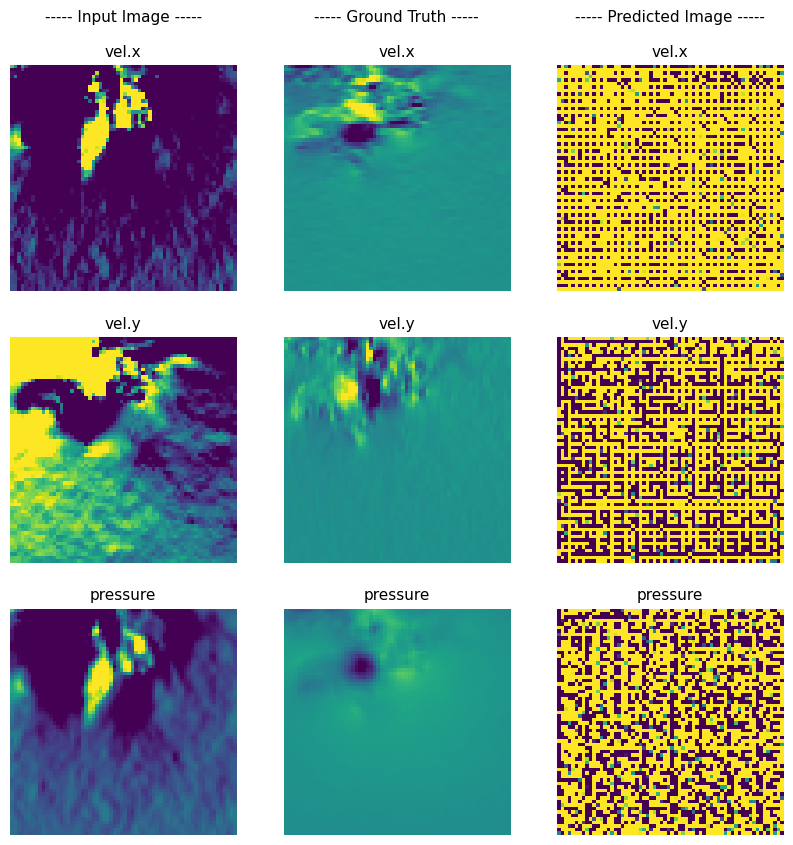

In [12]:
# Test untrained generator and preview.
prev_idx = 10
generate_images(generator, X_train[prev_idx][tf.newaxis, ...], Y_train[prev_idx][tf.newaxis, ...])

In [13]:
# APPLY BATCHING (with 1)
# ... and achieve output dimensionality of:     [2,     n, 64, 64, 3] 
# ... with desired iteration dimensionality of:     [None, 64, 64, 3]
import tensorflow as tf

X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_test = tf.cast(Y_test, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices( (np.array(X_train), np.array(Y_train)) )
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.batch(5)

test_ds = tf.data.Dataset.from_tensor_slices( (np.array(X_test), np.array(Y_test)) )
test_ds = test_ds.shuffle(1000)
test_ds = test_ds.batch(5)

In [14]:
import os
log_dir_root = "./logs"

def first_folder(directory):
  """Finds the alphabetically first folder in a directory."""
  folders = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isdir(f)]
  return min(folders, key=str.lower) if folders else None

log_dir=first_folder(log_dir_root)

%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --port=6010 --reload_multifile=true

Reusing TensorBoard on port 6010 (pid 34528), started 0:15:11 ago. (Use '!kill 34528' to kill it.)

In [15]:
# Initialize models
generator = build_generator()
discriminator = build_discriminator()

# Initialize trainer
trainer = FluidGANTrainer(
    generator=generator,
    discriminator=discriminator,
    train_dataset=train_ds,
    test_dataset=test_ds,
    checkpoint_dir='./training_checkpointsE',
    preview_interval=10,
    checkpoint_interval=50
)

# Start training
trainer.train(epochs=200)

Bottleneck shape before ResNet blocks: (None, 8, 8, 256)


ValueError: in user code:

    File "C:\Users\Martin Egger\AppData\Local\Temp\ipykernel_3576\2462206667.py", line 93, in train_step  *
        disc_losses = self.loss_fn.discriminator_loss(
    File "C:\Users\Martin Egger\AppData\Local\Temp\ipykernel_3576\2326638275.py", line 52, in discriminator_loss  *
        gp = self.gradient_penalty(y_true, y_pred, batch_size)
    File "C:\Users\Martin Egger\AppData\Local\Temp\ipykernel_3576\2326638275.py", line 80, in gradient_penalty  *
        return self._compute_gradient_penalty(interpolated)
    File "C:\Users\Martin Egger\AppData\Local\Temp\ipykernel_3576\2326638275.py", line 86, in _compute_gradient_penalty  *
        critic_interpolated = self.discriminator(interpolated_images)
    File "C:\Users\Martin Egger\.conda\envs\pressure_predict\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Martin Egger\.conda\envs\pressure_predict\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'add_2:0' shape=(5, 64, 64, 3) dtype=float32>]


In [ ]:
import netron
model = "./models/pressure_predict_D_v0.h5"
netron.start(model)